In [1]:
import json
import torch
import tqdm
import matplotlib.pyplot as plt
from src.datasets import get_dataset
from src.modules import get_model, get_loss_fn, get_optimizer

/Users/1X/Library/Python/3.8/lib/python/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def flatten(x):
    return x.flatten().detach().numpy()

def square(x):
    return x.unsqueeze(-1) * x.unsqueeze(-2)

def estimate(inputs, targets, model, loss_fn, num):
    loss_sum = 0
    output_sum = 0
    output_sum_sq = 0
    for _ in tqdm.trange(num):
        outputs = model(inputs)
        losses = loss_fn(outputs, targets)
        loss_sum += losses
        output_sum += outputs
        output_sum_sq += square(outputs)
    loss_mean = loss_sum / num
    output_mean = output_sum / num
    output_cov = output_sum_sq / num - square(output_mean)
    return loss_mean, (output_mean, output_cov)

In [3]:
with open("outputs/base_1/config.json") as f:
    base_config = json.load(f)
with open("outputs/dist_1/config.json") as f:
    dist_config = json.load(f)

dataset = get_dataset(base_config["dataset"])

base_model = get_model(base_config["model"], dataset.input_shape, dataset.num_classes)
base_loss_fn = get_loss_fn(base_config["fit"]["loss_fn"])
base_optimizer = get_optimizer(base_config["fit"]["optimizer"], base_model.parameters())

dist_model = get_model(dist_config["model"], dataset.input_shape, dataset.num_classes)
dist_loss_fn = get_loss_fn(dist_config["fit"]["loss_fn"])
dist_optimizer = get_optimizer(dist_config["fit"]["optimizer"], dist_model.parameters())


Files already downloaded and verified
Files already downloaded and verified


In [4]:
checkpoint = torch.load("outputs/base_1/checkpoint-20.pt")
base_model.load_state_dict(checkpoint["model"])
dist_model.load_state_dict(checkpoint["model"])

for inputs, targets in dataset.test_loader:
    break

dist_optimizer.zero_grad()
dist_outputs = dist_model(inputs)
dist_losses = dist_loss_fn(dist_outputs, targets)
dist_losses.mean().backward()

base_model.train()
base_optimizer.zero_grad()
base_losses, base_outputs = estimate(
    inputs, targets, base_model, base_loss_fn, 1000)
base_losses.mean().backward()

100%|██████████| 1000/1000 [00:05<00:00, 175.88it/s]


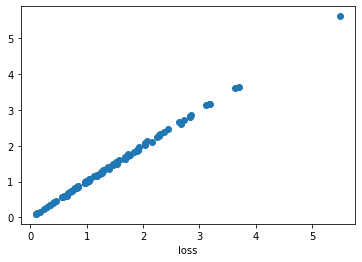

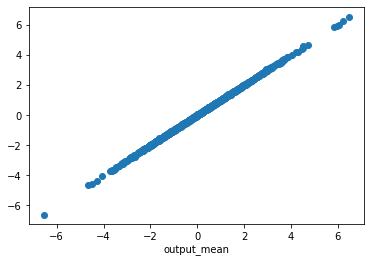

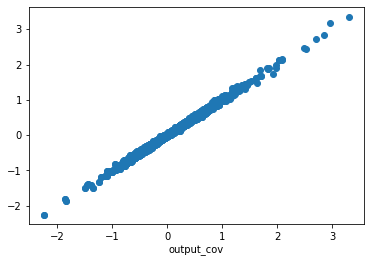

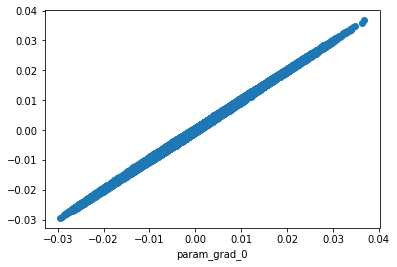

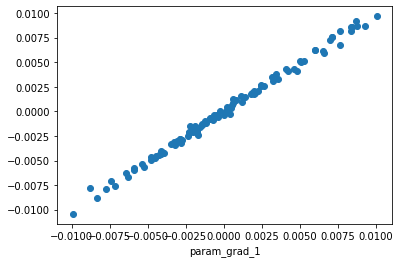

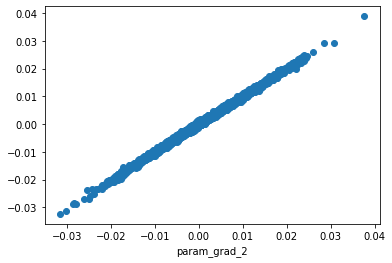

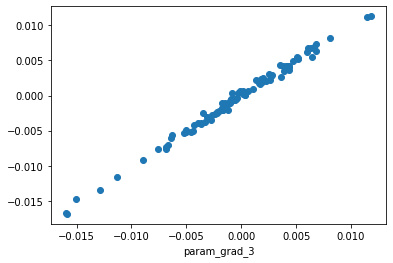

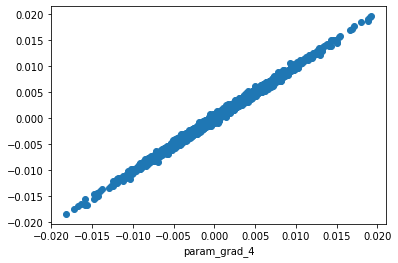

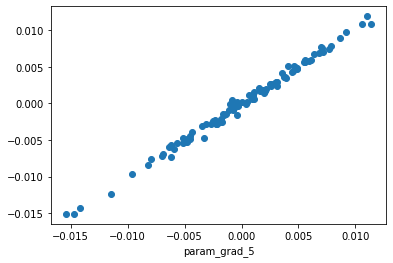

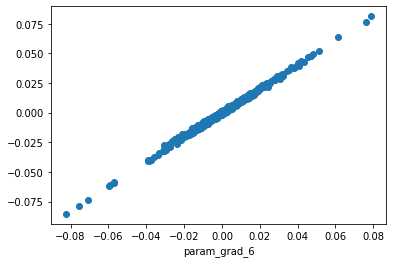

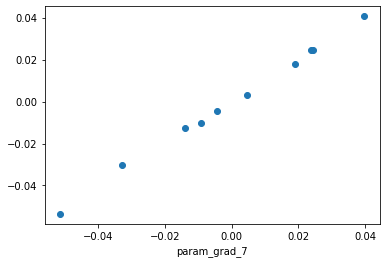

In [5]:
plt.figure()
plt.scatter(flatten(dist_losses), flatten(base_losses))
plt.xlabel(f"loss")
plt.figure()
plt.scatter(flatten(dist_outputs[0]), flatten(base_outputs[0]))
plt.xlabel(f"output_mean")
plt.figure()
plt.scatter(flatten(dist_outputs[1]), flatten(base_outputs[1]))
plt.xlabel(f"output_cov")
for i, (dist_param, base_param) in enumerate(
    zip(dist_model.parameters(), base_model.parameters())):
    plt.figure()
    plt.scatter(flatten(dist_param.grad), flatten(base_param.grad))
    plt.xlabel(f"param_grad_{i}")